In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To try:
1. Apply PCA for features
2. Eventually change feature extraction

In [ ]:
project_path = "/content/drive/MyDrive/Colab Notebooks/Artificial Vision/Project1/"
cdataset_path = project_path + "Clean Dataset"
odataset_path = project_path + "Original Dataset"
resized_directory = project_path + "Resized"

## 1. Loading images and labeling

In [ ]:
import os
import cv2

base_dir =  cdataset_path

# INPUT A FOLDER WITH CORRECT SUBFOLDER NAMES
categories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

enhanced_images = []
labels = []

for category in categories:
    class_folder = os.path.join(base_dir, category)
    for filename in os.listdir(class_folder):
        if filename.endswith(".jpg"):
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (600, 600))
            enhanced_images.append(img)
            labels.append(category)


In [ ]:
print(f"Images:{len(enhanced_images)}")
print(f"Labels: {len(labels)}")

Images:624
Labels: 624


## 2. Feature Extraction using BRISK

In [ ]:
all_features = []
for img in enhanced_images:
    brisk = cv2.BRISK_create()
    _, des = brisk.detectAndCompute(img, None)
    if des is not None:
        all_features.append(des)

print(f"Features obtained through BRISK: {len(all_features)}")

Features obtained through BRISK: 624


##2.5.1 Calculate optimal k

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

all_features_stacked = np.vstack(all_features)

distortions = []
K_range = range(10, 200, 10)  # example range from 10 to 200 with intervals of 10
for k in K_range:
    kmeanModel = MiniBatchKMeans(n_clusters=k, init='k-means++', batch_size=100, max_iter=300)
    kmeanModel.fit(all_features_stacked)
    distortions.append(kmeanModel.inertia_)




##2.5.2 Calculate optimal k

In [ ]:
# Calculate the distances of each point to the line formed by the first and last point
first_point = [K_range[0], distortions[0]]
last_point = [K_range[-1], distortions[-1]]

line_vector = np.array(last_point) - np.array(first_point)
line_vector_norm = line_vector / np.sqrt(sum(line_vector**2))

vec_from_first = np.array([K_range, distortions]).T - np.array(first_point)
scalar_product = np.dot(vec_from_first, line_vector_norm)
vec_from_first_projection = np.outer(scalar_product, line_vector_norm)
vec_to_line = vec_from_first - vec_from_first_projection

dist_to_line = np.sqrt(np.sum(vec_to_line**2, axis=1))

# Find the elbow point
K = K_range[np.argmax(dist_to_line)]

print(f"Optimal number of clusters (K) is: {K}")

Optimal number of clusters (K) is: 60


## 3. Create Kmeans Cluster

In [ ]:
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans
#all_features_stacked = np.vstack(all_features)

K = 35
# Use Kmeans FULL
#kmeans = KMeans(n_clusters=K).fit(all_features_stacked)

# Use MiniBatchKMeans for faster clustering
kmeans = MiniBatchKMeans(n_clusters=K, init='k-means++', batch_size=100, max_iter=300).fit(all_features_stacked)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## 4. Histogram Creation

In [ ]:
image_features = []
for des in all_features:
    histogram = np.zeros(K)
    if des is not None:
        predicted_cluster = kmeans.predict(des)
        for cluster in predicted_cluster:
            histogram[cluster] += 1
    image_features.append(histogram)


## 5. Normalize Histograms

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(image_features)
image_features = scaler.transform(image_features)


## 6. Classify using KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_features, labels, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)


## 7. Evaluate through metrics

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}% for {K} clusters \n for {base_dir} \n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 48.80% for 35 clusters 
 for /content/drive/MyDrive/Colab Notebooks/Artificial Vision/Project1/Clean Dataset 

Classification Report:
                      precision    recall  f1-score   support

      cheetahs_clean       0.11      0.29      0.16         7
 eurasian_lynx_clean       0.16      0.23      0.19        13
      leopards_clean       0.67      0.43      0.52        14
         lions_clean       0.79      0.58      0.67        19
mountain_lions_clean       0.36      0.24      0.29        21
      panthers_clean       1.00      1.00      1.00         7
 snow_leopards_clean       0.67      0.53      0.59        19
        tigers_clean       0.59      0.68      0.63        25

            accuracy                           0.49       125
           macro avg       0.54      0.50      0.50       125
        weighted avg       0.55      0.49      0.51       125

Confusion Matrix:
[[ 2  0  2  0  0  0  0  3]
 [ 1  3  0  0  3  0  3  3]
 [ 6  0  6  0  0  0  0  2]
 [ 2  2  0

## Testing accuracies to find best K

In [ ]:
k_values = list(range(1, 80))
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
print(sorted(accuracies))

[0.36, 0.376, 0.392, 0.392, 0.4, 0.4, 0.4, 0.408, 0.408, 0.408, 0.416, 0.416, 0.416, 0.416, 0.416, 0.424, 0.424, 0.424, 0.424, 0.424, 0.424, 0.424, 0.424, 0.424, 0.424, 0.424, 0.432, 0.432, 0.432, 0.432, 0.432, 0.432, 0.432, 0.432, 0.432, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.448, 0.448, 0.448, 0.448, 0.448, 0.448, 0.448, 0.456, 0.456, 0.456, 0.456, 0.456, 0.456, 0.456, 0.456, 0.456, 0.456, 0.456, 0.456, 0.464, 0.464, 0.464, 0.464, 0.464, 0.464, 0.464, 0.464, 0.472, 0.472, 0.48, 0.48, 0.48, 0.48, 0.488, 0.488, 0.504]


## Sort obtained accuracies to find out the best K

In [ ]:
results = list(zip(k_values, accuracies))
sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
print("Top 10 K values and their accuracies:")
for k, acc in sorted_results[:10]:
    print(f"K = {k}, Accuracy = {acc:.4f}")


Top 10 K values and their accuracies:
K = 6, Accuracy = 0.5040
K = 5, Accuracy = 0.4880
K = 7, Accuracy = 0.4880
K = 8, Accuracy = 0.4800
K = 9, Accuracy = 0.4800
K = 25, Accuracy = 0.4800
K = 27, Accuracy = 0.4800
K = 18, Accuracy = 0.4720
K = 30, Accuracy = 0.4720
K = 12, Accuracy = 0.4640


##One more try to obtain the optimal K

In [ ]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

all_features_stacked = np.vstack(all_features)

K_range = range(10, 101, 10)
num_trials = 5
average_accuracies = []

# Iterate over all K values
for k in K_range:
    temp_accuracies = []

    # Run the entire pipeline multiple times
    for _ in range(num_trials):
        # 2. Clustering
        kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++', batch_size=100, max_iter=300, random_state=None)
        kmeans.fit(all_features_stacked)

        # 3. & 4. Histogram Generation and Normalization
        image_features = []
        for des in all_features:
            histogram = np.zeros(k)
            if des is not None:
                predicted_cluster = kmeans.predict(des)
                for cluster in predicted_cluster:
                    histogram[cluster] += 1
            image_features.append(histogram)
        scaler = StandardScaler().fit(image_features)
        image_features = scaler.transform(image_features)

        # 5. Classification with KNN
        X_train, X_test, y_train, y_test = train_test_split(image_features, labels, test_size=0.2)
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        # 6. Measure Accuracy
        acc = accuracy_score(y_test, y_pred)
        temp_accuracies.append(acc)

    # 7. Average the accuracies
    average_accuracies.append(np.mean(temp_accuracies))

# 8. Get K with the highest average accuracy
optimal_K = K_range[np.argmax(average_accuracies)]
print(f"Optimal number of clusters (K) based on accuracy is: {optimal_K}")


## Classifing with SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans

optimal_K = 35
optimal_kmeans = MiniBatchKMeans(n_clusters=optimal_K, init='k-means++', batch_size=100, max_iter=300)
optimal_kmeans.fit(all_features_stacked)

image_features = []
for des in all_features:
    histogram = np.zeros(optimal_K)
    if des is not None:
        predicted_cluster = optimal_kmeans.predict(des)
        for cluster in predicted_cluster:
            histogram[cluster] += 1
    image_features.append(histogram)

# Normalize
scaler = StandardScaler().fit(image_features)
normalized_features = scaler.transform(image_features)

X_train, X_test, y_train, y_test = train_test_split(normalized_features, labels, test_size=0.2)

# Using Support Vector Machine
svc = SVC(kernel='linear', C=1)  # You can adjust the kernel and C parameter based on your needs
svc.fit(X_train, y_train)

y_pred_svc = svc.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"Classification accuracy with SVC and {optimal_K}K: {accuracy_svc*100:.2f}%")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Classification accuracy with SVC and 35K: 58.40%


## Tryinh KNN again

In [ ]:
optimal_K = 20  # Ensure this is consistent with n_clusters in MiniBatchKMeans
optimal_kmeans = MiniBatchKMeans(n_clusters=optimal_K, init='k-means++', batch_size=100, max_iter=300)
optimal_kmeans.fit(all_features_stacked)

image_features = []
for des in all_features:
    histogram = np.zeros(optimal_K)  # Ensure the histogram size is consistent with the number of clusters
    if des is not None:
        predicted_cluster = optimal_kmeans.predict(des)
        for cluster in predicted_cluster:
            histogram[cluster] += 1
    image_features.append(histogram)

# Normalize
scaler = StandardScaler().fit(image_features)
normalized_features = scaler.transform(image_features)

X_train, X_test, y_train, y_test = train_test_split(normalized_features, labels, test_size=0.2)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy with optimal K:{optimal_K} {accuracy*100}%")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Classification accuracy with optimal K:20 44.800000000000004%


## Ploting avc acc

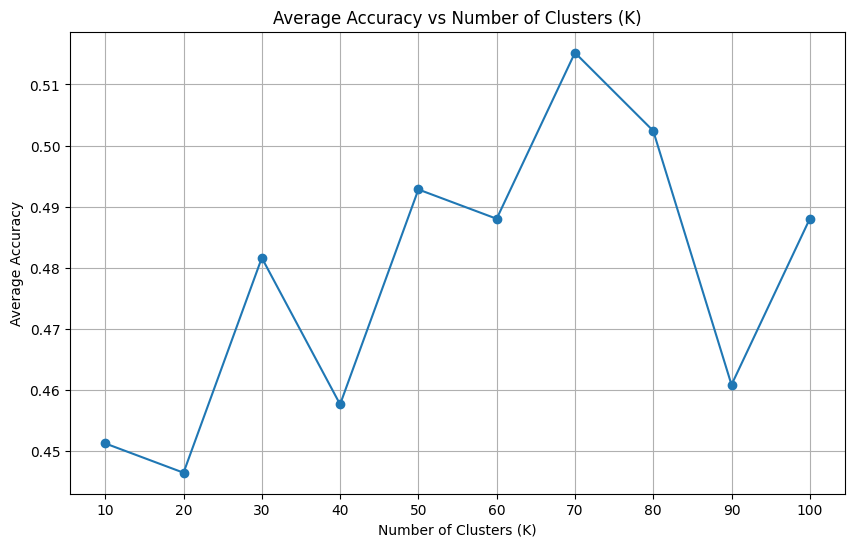

In [ ]:
import matplotlib.pyplot as plt

# ... [Your provided code]

# Plotting the average accuracy for each K
plt.figure(figsize=(10,6))
plt.plot(K_range, average_accuracies, marker='o', linestyle='-')
plt.title('Average Accuracy vs Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Accuracy')
plt.grid(True)
plt.xticks(K_range)
plt.show()


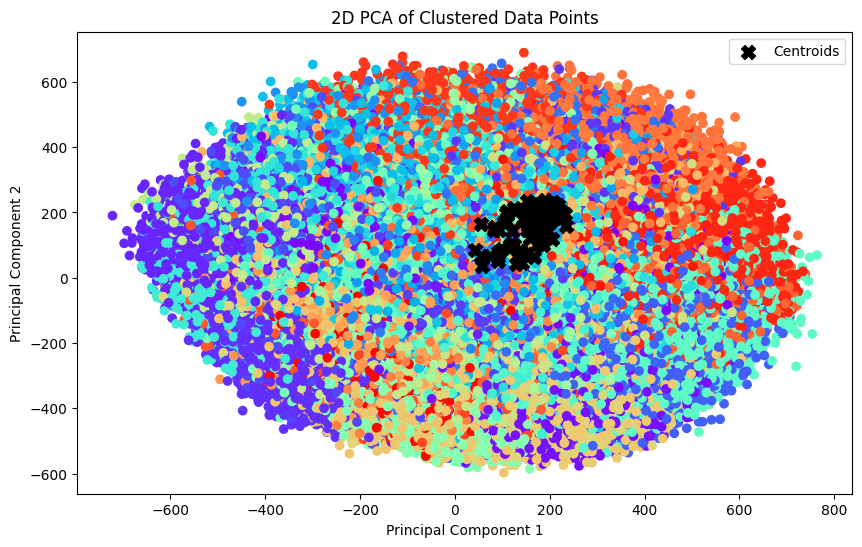

In [40]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ... [your existing imports and code]

# After obtaining the kmeans clustering result, let's visualize it
pca = PCA(n_components=2) # Reduce dimensionality to 2D
reduced_features = pca.fit_transform(all_features_stacked)

# Predict the cluster for each data point
predicted_clusters = kmeans.predict(all_features_stacked)

plt.figure(figsize=(10,6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=predicted_clusters, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', marker='X', label='Centroids')
plt.title('2D PCA of Clustered Data Points')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
#

In [41]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans

optimal_K = 35
optimal_kmeans = MiniBatchKMeans(n_clusters=optimal_K, init='k-means++', batch_size=100, max_iter=300)
optimal_kmeans.fit(all_features_stacked)

image_features = []
for des in all_features:
    histogram = np.zeros(optimal_K)
    if des is not None:
        predicted_cluster = optimal_kmeans.predict(des)
        for cluster in predicted_cluster:
            histogram[cluster] += 1
    image_features.append(histogram)

# Normalize
scaler = StandardScaler().fit(image_features)
normalized_features = scaler.transform(image_features)

X_train, X_test, y_train, y_test = train_test_split(normalized_features, labels, test_size=0.2)

# Using Support Vector Machine
svc = SVC(kernel='linear', C=1)  # You can adjust the kernel and C parameter based on your needs
svc.fit(X_train, y_train)

y_pred_svc = svc.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"Classification accuracy with SVC and {optimal_K}K: {accuracy_svc*100:.2f}%")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Classification accuracy with SVC and 35K: 53.60%


In [44]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y):
    # Create a grid
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict on the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Ensure you only have 2 features for this to work
if X_train.shape[1] == 2:
    plot_decision_boundary(svc, X_train, y_train)
else:
    print("Cannot directly plot decision boundary for data with more than 2 features.")


Cannot directly plot decision boundary for data with more than 2 features.


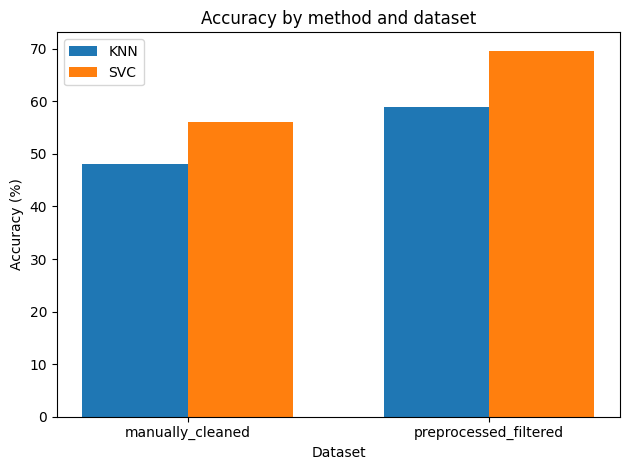

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
methods = ['KNN', 'SVC']
datasets = ['manually_cleaned', 'preprocessed_filtered']
results = {
    'KNN': [48, 59.02],
    'SVC': [56, 69.67]
}

# Create a bar chart
bar_width = 0.35
index = np.arange(len(datasets))
fig, ax = plt.subplots()

for i, method in enumerate(methods):
    ax.bar(index + i * bar_width, results[method], bar_width, label=method)

# Describe the data
ax.set_xlabel('Dataset')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy by method and dataset')
ax.set_xticks(index + bar_width / 2)  # Position of dataset labels
ax.set_xticklabels(datasets)
ax.legend()

plt.tight_layout()
plt.show()


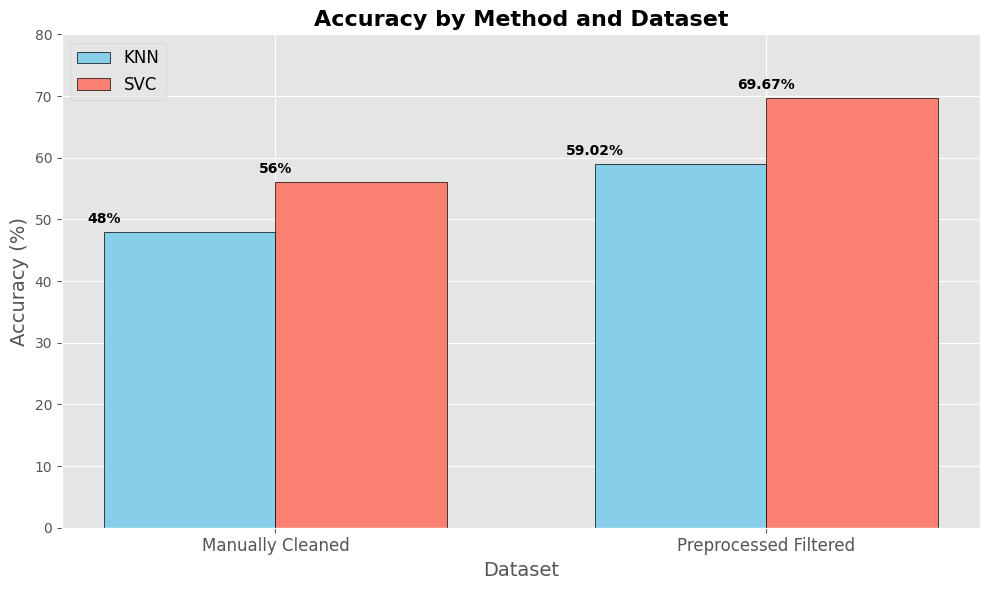

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
methods = ['KNN', 'SVC']
datasets = ['Manually Cleaned', 'Preprocessed Filtered']
results = {
    'KNN': [48, 59.02],
    'SVC': [56, 69.67]
}

# Set a style and color palette
plt.style.use('ggplot')
colors = ['skyblue', 'salmon']

# Create a bar chart
bar_width = 0.35
index = np.arange(len(datasets))
fig, ax = plt.subplots(figsize=(10, 6))

for i, method in enumerate(methods):
    ax.bar(index + i * bar_width, results[method], bar_width, label=method, color=colors[i], edgecolor='black')

# Add value labels on top of the bars
for i, v in enumerate(results['KNN']):
    ax.text(i - bar_width/2, v + 1, f"{v}%", ha='center', va='bottom', fontweight='bold', color='black')

for i, v in enumerate(results['SVC']):
    ax.text(i + bar_width/2, v + 1, f"{v}%", ha='center', va='bottom', fontweight='bold', color='black')

# Describe the data
ax.set_xlabel('Dataset', fontsize=14)
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.set_title('Accuracy by Method and Dataset', fontsize=16, fontweight='bold')
ax.set_xticks(index + bar_width / 2)  # Position of dataset labels
ax.set_xticklabels(datasets, fontsize=12)
ax.legend(fontsize=12)
ax.set_ylim(0, 80)  # set the y-axis limit for better visualization

plt.tight_layout()
plt.show()
